##Setup Kaggle and Import Dataset




In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kmarsyad","key":"0b2fab08fb1915b97629ea87647e49a5"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out

 99% 2.09G/2.11G [00:52<00:00, 49.3MB/s]
100% 2.11G/2.11G [00:52<00:00, 42.8MB/s]


In [6]:
! unzip /content/asl-rgb-depth-fingerspelling-spelling-it-out.zip -d /input

Streaming output truncated to the last 5000 lines.
  inflating: /input/dataset5/E/u/color_20_0231.png  
  inflating: /input/dataset5/E/u/color_20_0232.png  
  inflating: /input/dataset5/E/u/color_20_0233.png  
  inflating: /input/dataset5/E/u/color_20_0234.png  
  inflating: /input/dataset5/E/u/color_20_0235.png  
  inflating: /input/dataset5/E/u/color_20_0236.png  
  inflating: /input/dataset5/E/u/color_20_0237.png  
  inflating: /input/dataset5/E/u/color_20_0238.png  
  inflating: /input/dataset5/E/u/color_20_0239.png  
  inflating: /input/dataset5/E/u/color_20_0240.png  
  inflating: /input/dataset5/E/u/color_20_0241.png  
  inflating: /input/dataset5/E/u/color_20_0242.png  
  inflating: /input/dataset5/E/u/color_20_0243.png  
  inflating: /input/dataset5/E/u/color_20_0244.png  
  inflating: /input/dataset5/E/u/color_20_0245.png  
  inflating: /input/dataset5/E/u/color_20_0246.png  
  inflating: /input/dataset5/E/u/color_20_0247.png  
  inflating: /input/dataset5/E/u/color_20_0248.p

## Import Environments

In [7]:
from tensorflow import keras
from keras import optimizers
from keras.applications.vgg19 import VGG19
import os, pathlib
import pandas as pd
import numpy as np
import tensorflow as tf

In [8]:
print(os.listdir("../input"))

['dataset5']


## Store Labels and Images to Dictionary

In [9]:
import glob

def get_labels_images(path):
  asl_dict = {}

  for dir in glob.glob(path):
    image_array = []
    for image in glob.glob(dir+'/color_*.png'):
      image_array.append(image)
    asl_dict.setdefault(dir[-1], image_array)

  return asl_dict

In [10]:
data_dir = os.path.abspath('../input/dataset5/*/*')
asl_dict = get_labels_images(data_dir)

## Display data samples

In [11]:
import cv2
import matplotlib.pyplot as plt

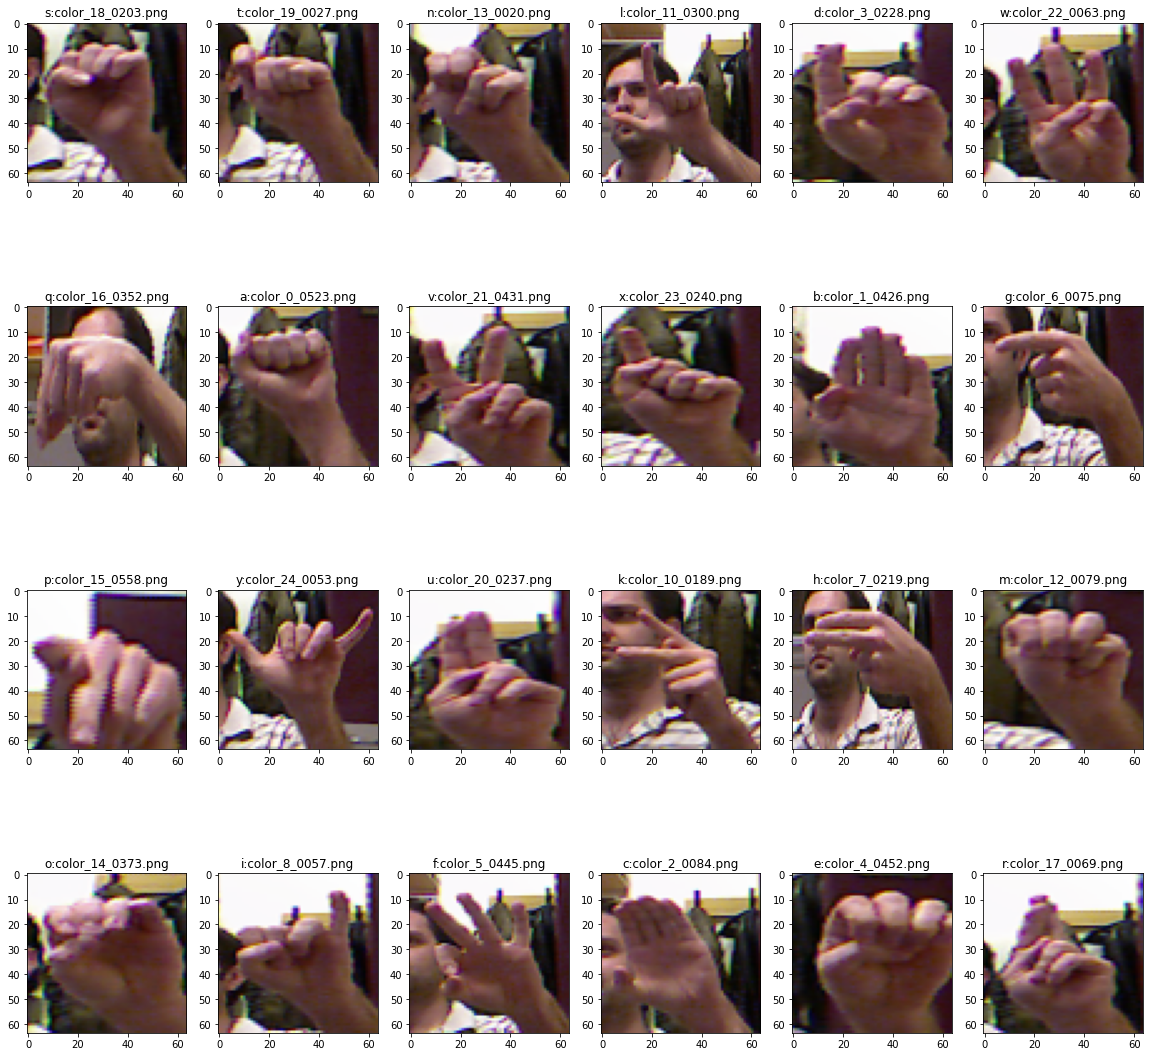

In [12]:
plt.figure(figsize = (20,20))

for i, (k,v) in enumerate(asl_dict.items()):
    image = cv2.imread(v[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64,64))
    plt.subplot(4,6,i+1)
    plt.imshow(image)
    plt.title(k + ":" + os.path.basename(v[0]))
    
plt.show()

## Preprocess 

In [13]:
def prep_img(dict):
  images = []
  labels = []
  height = 64
  width = 64
  for k,v in dict.items():
    for file in v:
      image = cv2.imread(file)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #channel
      image = cv2.resize(image, (height, width))  #size
      image = image / 255.  #normalize
      images.append(image)
      labels.append(k)
    
  return (np.array(images), np.array(labels).reshape(-1,1))
          

In [15]:
images, labels = prep_img(asl_dict)

## Encode labels

In [16]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

## Create Train, Dev, Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1)

print('Number of training samples: {}, Shape: {}'.format(len(X_train), X_train.shape))
print('Number of dev samples: {}, Shape: {}'.format(len(X_dev), X_dev.shape))
print('Number of test samples: {}, Shape: {}'.format(len(X_test), X_test.shape))

Number of training samples: 7527, Shape: (7527, 64, 64, 3)
Number of dev samples: 2510, Shape: (2510, 64, 64, 3)
Number of test samples: 2510, Shape: (2510, 64, 64, 3)


## Display some images

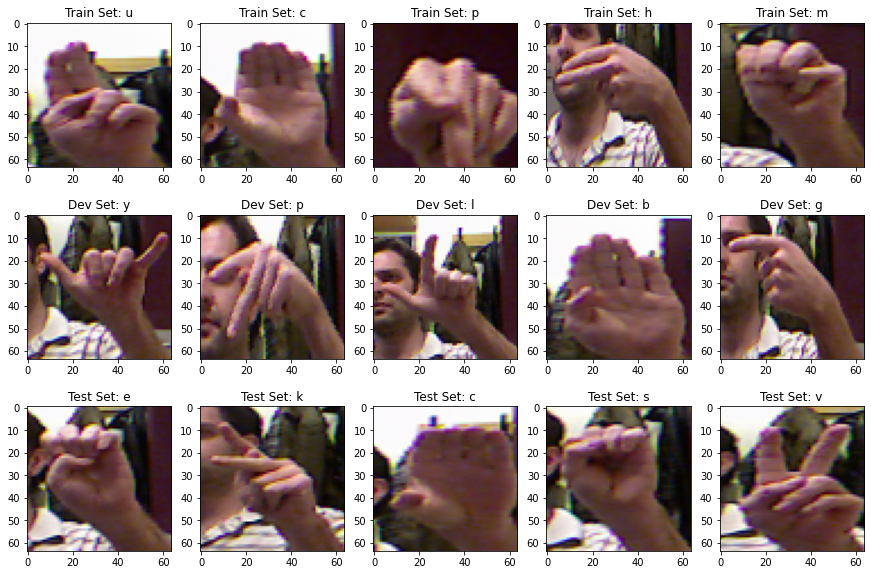

In [18]:
plt.figure(figsize = (15,10))

for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(X_train[i])
    plt.title('Train Set: {}'.format(label_binarizer.classes_[np.argmax(Y_train[i], axis = -1)]))

for i in range(5,10):
    plt.subplot(3,5,i+1)
    plt.imshow(X_dev[i])
    plt.title('Dev Set: {}'.format(label_binarizer.classes_[np.argmax(Y_dev[i], axis = -1)]))

for i in range(10,15):
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[i])
    plt.title('Test Set: {}'.format(label_binarizer.classes_[np.argmax(Y_test[i], axis = -1)]))

plt.show()

## Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,  MaxPooling2D,  Activation, Dense, Flatten, Dropout


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (64,64,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(24, activation = 'softmax'))

In [20]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 58, 58, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 54, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 64)       0

In [21]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=0,factor=0.5, min_lr=0.00001)

In [22]:
# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose = 0, restore_best_weights = True)]

# history = model.fit(X_train, Y_train,
#                     epochs = 10,
#                     batch_size = 128,
#                     validation_data = (X_dev, Y_dev),
#                     callbacks = callbacks)

from datetime import datetime 
batch_size=16
start1 = datetime.now() 
history = model.fit(X_train, Y_train, 
                    batch_size = 128 ,
                    epochs = 20 , 
                    validation_data = (X_dev, Y_dev), 
                    callbacks = [learning_rate_reduction])

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Epoch 1/20
59/59 [==============================] - 20s 113ms/step - loss: 0.9342 - accuracy: 0.7360 - val_loss: 0.1066 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - 5s 90ms/step - loss: 0.0789 - accuracy: 0.9773 - val_loss: 0.0738 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 3/20
59/59 [==============================] - 5s 91ms/step - loss: 0.0257 - accuracy: 0.9926 - val_loss: 0.0519 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 4/20
59/59 [==============================] - 5s 91ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0360 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 5/20
59/59 [==============================] - 5s 92ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0403 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 6/20
59/59 [==============================] - 5s 87ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.0896 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 7/20
59/59 [==============================] - 5s 87ms/step - loss: 0

## Evaluate model on test set

In [23]:
eval_loss, eval_acc = model.evaluate(X_test, Y_test)
print('Evaluation Loss: {:.4f}, Evaluation Accuracy: {:.2f}'.format(eval_loss, eval_acc * 100))

79/79 [==============================] - 1s 11ms/step - loss: 0.0170 - accuracy: 0.9960
Evaluation Loss: 0.0170, Evaluation Accuracy: 99.60


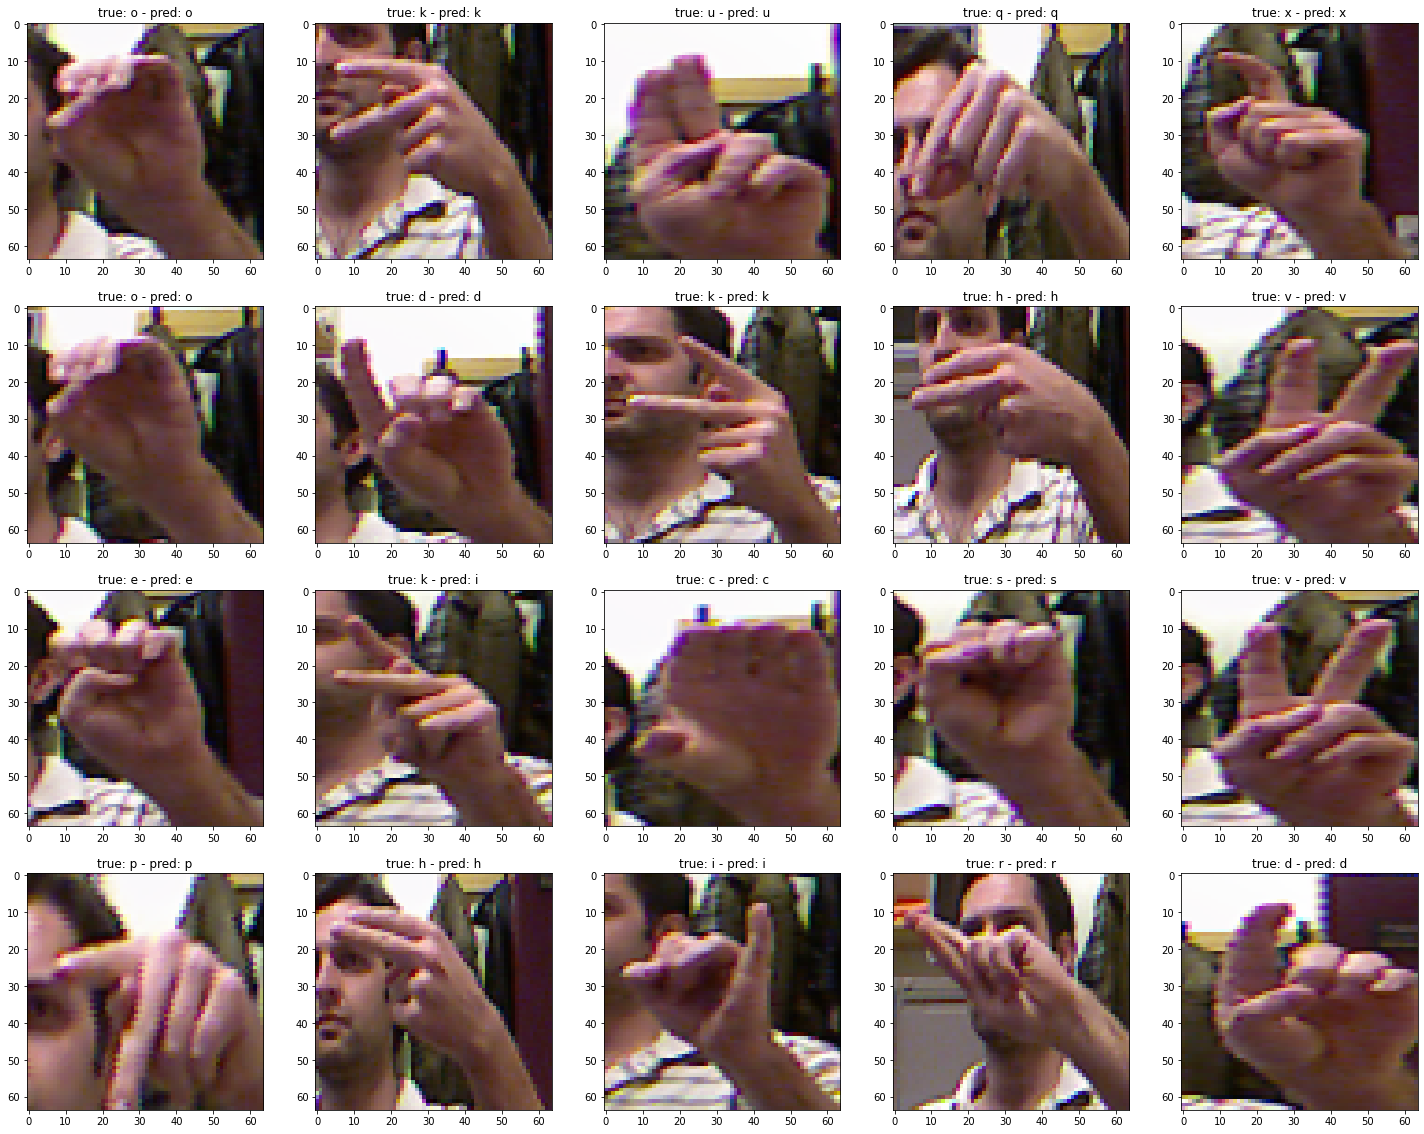

In [24]:
preds = model.predict(X_test)

plt.figure(figsize = (25,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.title('true: {} - pred: {}'.format(label_binarizer.classes_[np.argmax(Y_test[i], axis = -1)], label_binarizer.classes_[np.argmax(preds[i], axis = -1)]))
    
plt.show()

## Convert Model to TFLite

In [25]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/ASL_TFLite'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/ASL_TFLite/assets


In [26]:
# Select mode of optimization
mode = "Storage" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [27]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [28]:
tflite_model_file = pathlib.Path('./ASL.tflite')
tflite_model_file.write_bytes(tflite_model)

6062208

## Test with Custom Images

In [29]:
uploaded = files.upload()

Saving asl-a-new-cropped.jpg to asl-a-new-cropped.jpg


In [ ]:
def prepare_custom_images(filepath):
  img = cv2.imread(filepath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  height = 64
  width = 64
  img = cv2.resize(img, (height, width))
  img = img / 255.
  print(img.shape)
    
  return np.array(img)



In [ ]:
custom_images_path = "/content/test-B-cropped.jpg"
custom_images = prepare_custom_images(custom_images_path)

(64, 64, 3)


In [ ]:
prediction = model.predict(prepare_custom_images(custom_images_path))

(64, 64, 3)


ValueError: ignored

In [ ]:
custom_images.shape

(64, 64, 3)

In [ ]:
custom_preds = model.predict(prepare_custom_images(custom_images_path))
custom_preds



(64, 64, 3)


ValueError: ignored